# GTZAN Audio Classification & Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import learning_curve
from IPython.display import Audio, display

In [3]:
dataset_path = "/content/drive/MyDrive/AI/data/genres_original"
genres = os.listdir(dataset_path)

for genre in genres:
    print(f"Genre: {genre}")
    genre_path = os.path.join(dataset_path, genre)
    files = os.listdir(genre_path)
    print(f"Number of files: {len(files)}")

Genre: rock
Number of files: 100
Genre: country
Number of files: 100
Genre: classical
Number of files: 100
Genre: hiphop
Number of files: 100
Genre: blues
Number of files: 100
Genre: pop
Number of files: 100
Genre: reggae
Number of files: 100
Genre: jazz
Number of files: 99
Genre: disco
Number of files: 100
Genre: metal
Number of files: 100


# Harmonic and Percussive Components Analysis

The harmonic–percussive source separation (HPSS) technique decomposes an audio signal into two layers:

- Harmonic (Blue) – Sustained, tonal elements (vocals, guitar chords, string sections).
- Percussive (Orange) – Rhythmic, transient elements (drum hits, sharp attacks).

By isolating these components, we gain insight into how each genre balances melodic/harmonic material versus rhythmic emphasis.

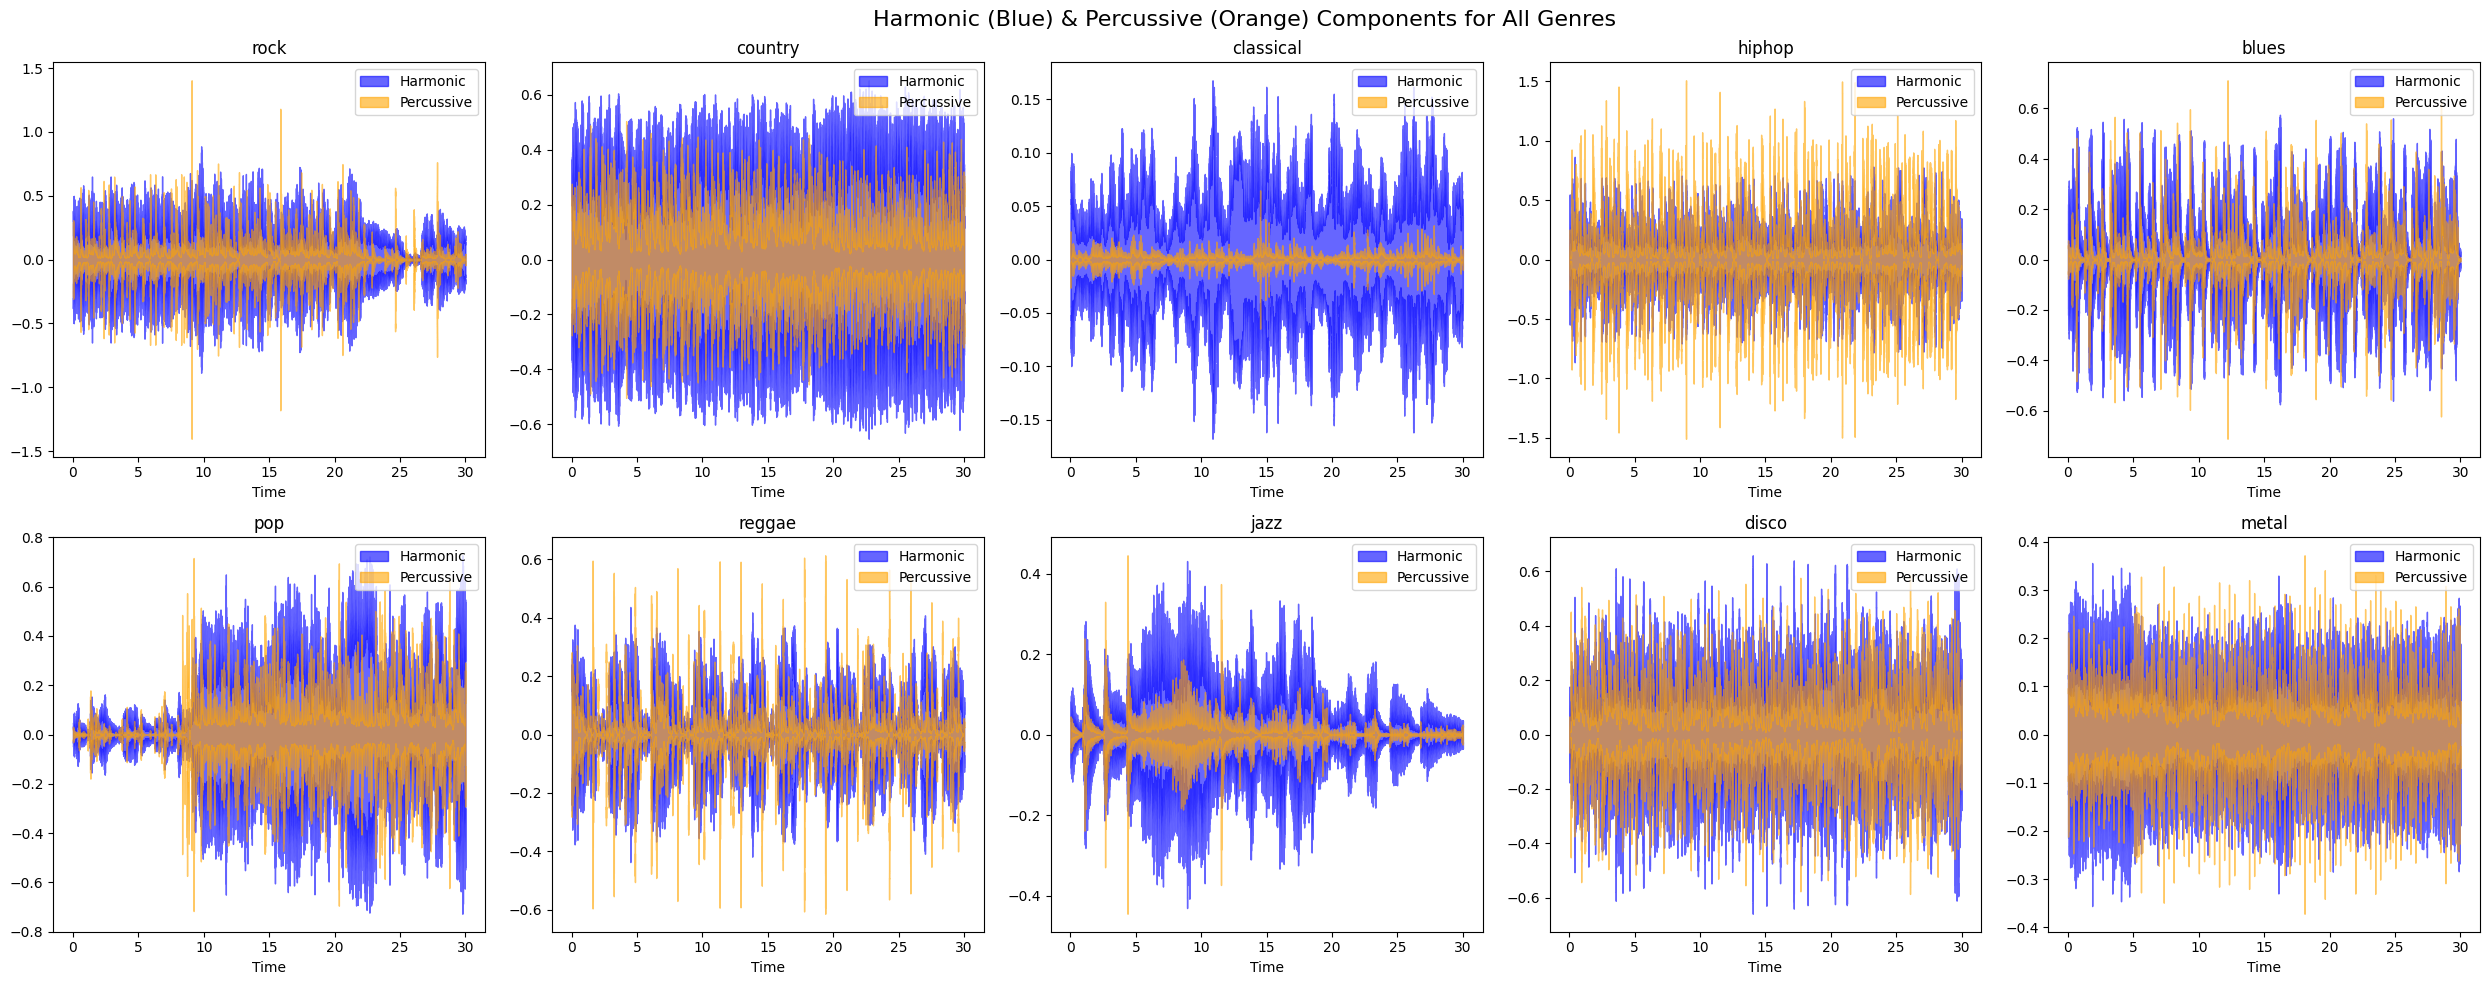

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Harmonic (Blue) & Percussive (Orange) Components for All Genres', fontsize=16)
axs = axs.flatten()

for i, genre in enumerate(genres):
    genre_path = os.path.join(dataset_path, genre)
    file_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    y, sr = librosa.load(file_path)

    y_harmonic, y_percussive = librosa.effects.hpss(y)

    librosa.display.waveshow(y_harmonic, sr=sr, ax=axs[i], color='blue', alpha=0.6, label='Harmonic')
    librosa.display.waveshow(y_percussive, sr=sr, ax=axs[i], color='orange', alpha=0.6, label='Percussive')

    axs[i].set_title(f'{genre}')
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

## What Can We Learn from These Plots?

- Classical and Jazz may emphasize smoother harmonic content (sustained notes, flowing chord progressions), with more subtle percussion elements.

- Large orange spikes indicate a strong rhythmic emphasis (heavy drum hits in Hip-Hop).

- Metal features strong percussive spikes (drums, aggressive attacks) layered with powerful harmonic elements (distorted guitars, sustained chords).

## MFCC (Mel-Frequency Cepstral Coefficients) Analysis
MFCCs are a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

## How it works?
1. The audio signal is divided into short frames (typically 20-40 ms) to capture temporal changes.

2. Each frame is converted from the time domain to the frequency domain using the Fast Fourier Transform (FFT).

3. The frequency spectrum is mapped to the mel scale, a nonlinear scale that approximates how humans perceive pitch. A set of triangular filters (mel filter bank) is applied to emphasize perceptually relevant frequencies.

4. The power spectrum is transformed using a logarithm to mimic the human ear's sensitivity to sound intensity (Logarithmic Compression).

5. Discrete Cosine Transform (DCT) is applied to decorrelate the filter bank energies and produce a compact set of coefficients (the MFCCs).

Genre: rock
  File: rock.00001.wav
  Audio length: 30.01 seconds
  Sampling rate: 22050 Hz
  MFCCs shape: (13, 1293)
  Mean of MFCCs: [-111.25285    134.15211    -24.65805     41.54234     -3.0750806
   28.475191   -10.59955     14.917008   -14.410271     8.844091
   -4.5479774    9.940146    -4.680241 ]
  Standard deviation of MFCCs: [56.16229  27.302845 17.846113 14.267754 11.456511  8.577427 12.110909
  7.341812 10.907551  7.040926  8.447067  7.875923  7.350308]
  Min/Max of MFCCs: -303.2377014160156/218.7515869140625
----------------------------------------
Genre: country
  File: country.00001.wav
  Audio length: 30.01 seconds
  Sampling rate: 22050 Hz
  MFCCs shape: (13, 1293)
  Mean of MFCCs: [-7.9727893  62.724636   -1.45917    28.109985    9.967061    9.363964
  5.415904    9.82543     3.0275455   8.420949    0.3107131   6.540354
  0.73737174]
  Standard deviation of MFCCs: [19.007256   9.6487665 12.17481    7.792583   8.578346  10.32275
  7.038028   7.3000255  7.7941136  7.404

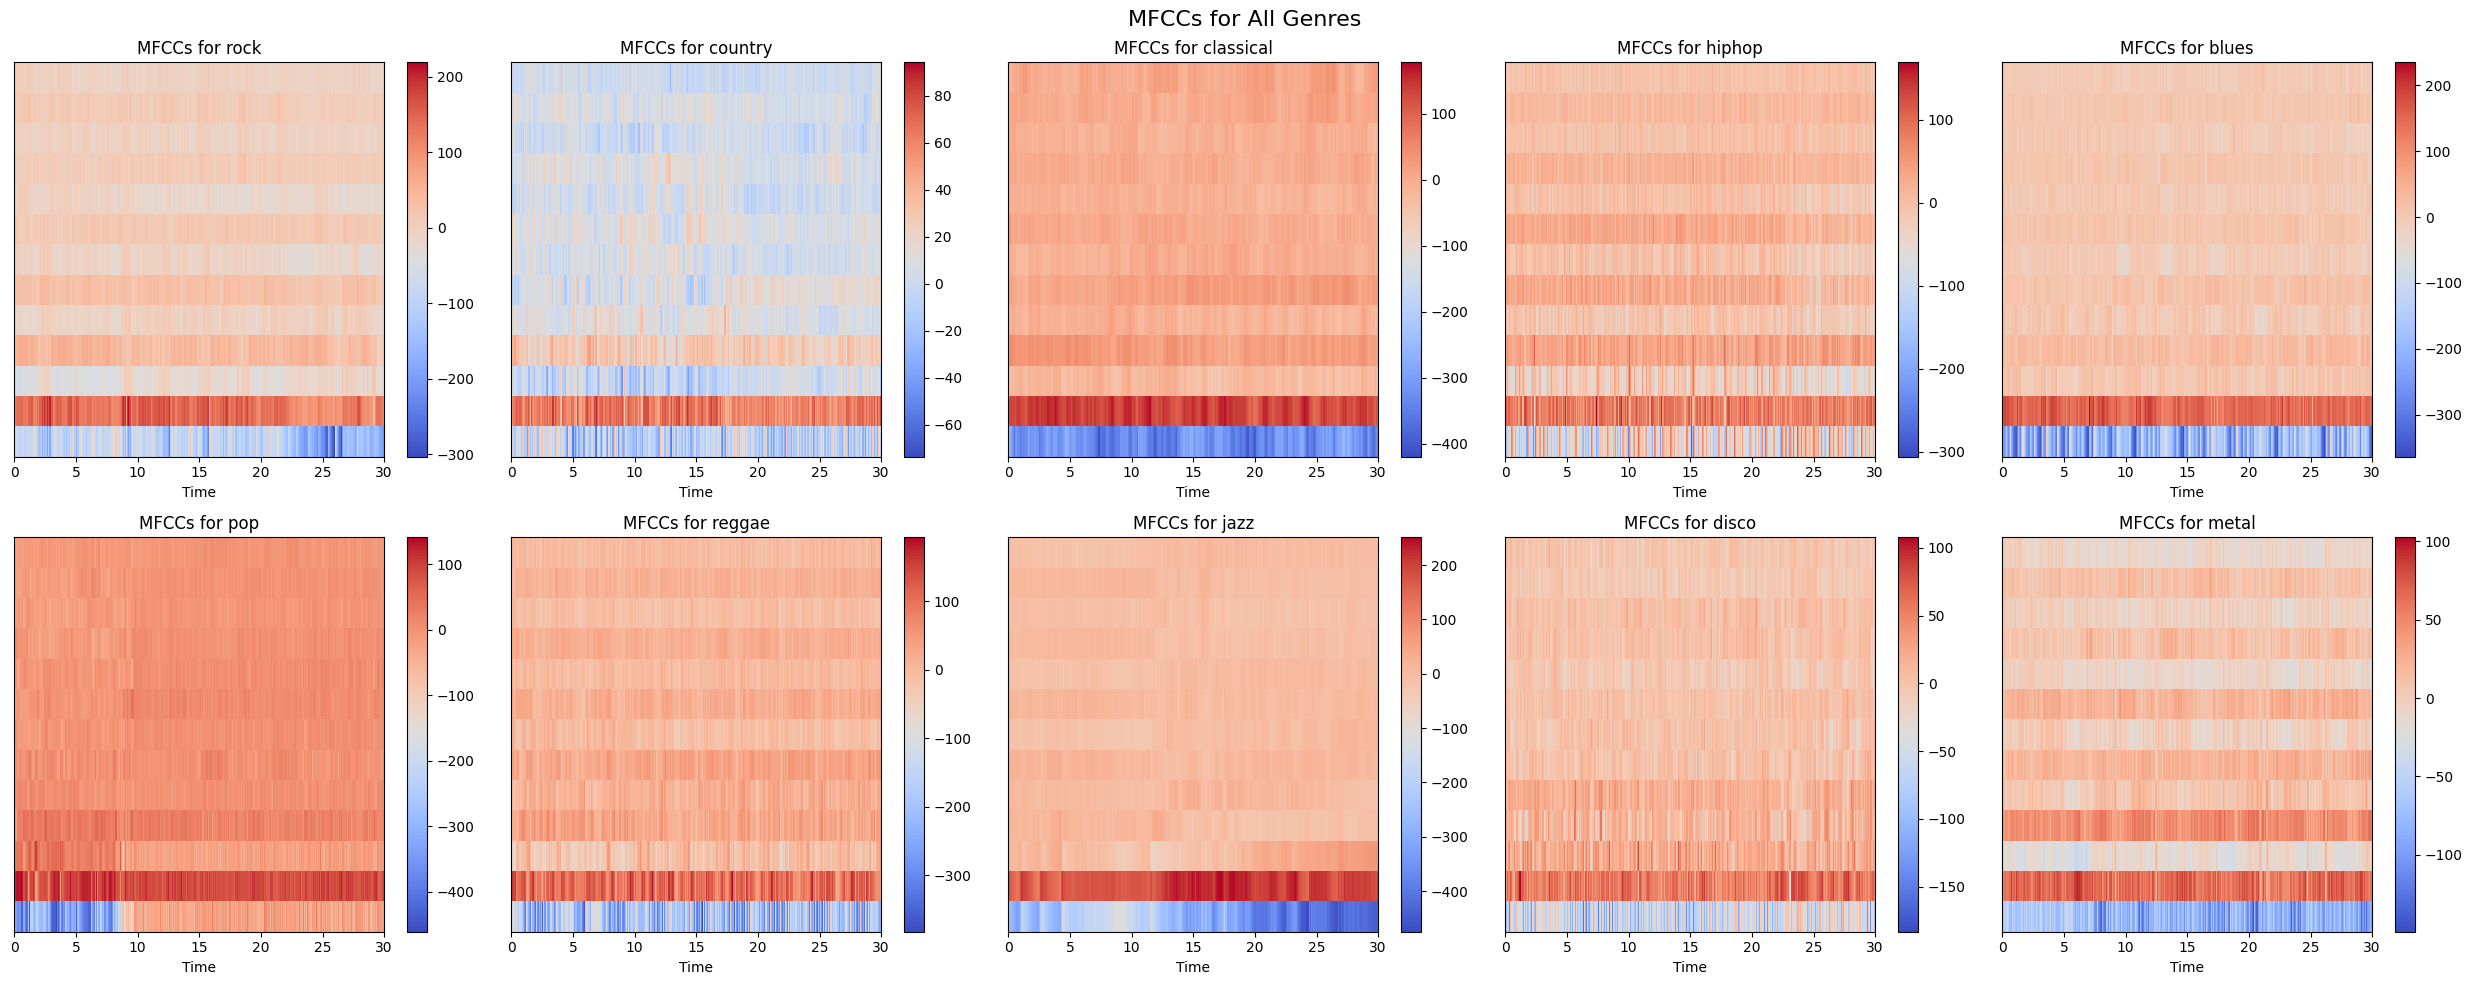

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('MFCCs for All Genres', fontsize=16)

axs = axs.flatten()

# Plot MFCCs
for i, genre in enumerate(genres):
    genre_path = os.path.join(dataset_path, genre)
    file_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    librosa.display.specshow(mfccs, x_axis='time', ax=axs[i])
    plt.colorbar(axs[i].collections[0], ax=axs[i])
    axs[i].set_title(f'MFCCs for {genre}')

    print(f"Genre: {genre}")
    print(f"  File: {os.listdir(genre_path)[0]}")
    print(f"  Audio length: {len(y) / sr:.2f} seconds")
    print(f"  Sampling rate: {sr} Hz")
    print(f"  MFCCs shape: {mfccs.shape}")
    print(f"  Mean of MFCCs: {np.mean(mfccs, axis=1)}")
    print(f"  Standard deviation of MFCCs: {np.std(mfccs, axis=1)}")
    print(f"  Min/Max of MFCCs: {np.min(mfccs)}/{np.max(mfccs)}")
    print("-" * 40)

plt.tight_layout()
plt.show()

### What Can We Learn from These Plots?

- Each genre has a unique "fingerprint" in its MFCCs, reflecting its musical characteristics (rhythm, harmony, timbre). Rock and metal might have more pronounced high-frequency components, while classical and jazz might have smoother transitions.

- The plots show how the audio features change over time. For instance, a sudden change in color intensity might indicate a transition between sections of the song.

- We can identify similarities (blues and jazz might share some patterns) and differences (classical and metal are likely very distinct).

## Chroma Analysis
Chroma features are a representation of the harmonic and melodic content of audio signals. They capture the distribution of energy across the 12 pitch classes in the chroma scale (derived from the Short-Time Fourier Transform (STFT)).

Each row corresponds to one pitch class, showing how much energy is present in that pitch class over time.

## How it works?
1. The audio signal is analyzed to identify the pitch content across the frequency spectrum.

2. Frequencies are mapped to their corresponding pitch classes, effectively "folding" all octaves into a single octave (for example, C2, C3, and C4 are all treated as "C").

3. The energy (magnitude) within each pitch class is summed up, resulting in a 12-dimensional vector representing the chroma features.

Genre: rock
  File: rock.00001.wav
  Chroma shape: (12, 1293)
  Mean of Chroma: [0.29498082 0.31911126 0.3383049  0.39390814 0.47899717 0.3133994
 0.27673933 0.30829057 0.4129999  0.4969466  0.39391893 0.3572556 ]
  Standard deviation of Chroma: [0.2963208  0.28665134 0.32374132 0.2478412  0.35629848 0.22523749
 0.27595904 0.2661584  0.3149113  0.3589979  0.2812964  0.28500462]
  Min/Max of Chroma: 0.004039403982460499/1.0
----------------------------------------
Genre: country
  File: country.00001.wav
  Chroma shape: (12, 1293)
  Mean of Chroma: [0.31558183 0.41513744 0.31909877 0.44664738 0.41662502 0.45482275
 0.6393338  0.421263   0.38003972 0.2614918  0.38873166 0.5098789 ]
  Standard deviation of Chroma: [0.19023198 0.26121807 0.19603366 0.3046578  0.30493045 0.23693493
 0.31076315 0.24652134 0.29229102 0.18929459 0.25851393 0.3389496 ]
  Min/Max of Chroma: 0.009301820769906044/1.0
----------------------------------------
Genre: classical
  File: classical.00001.wav
  Chroma sha

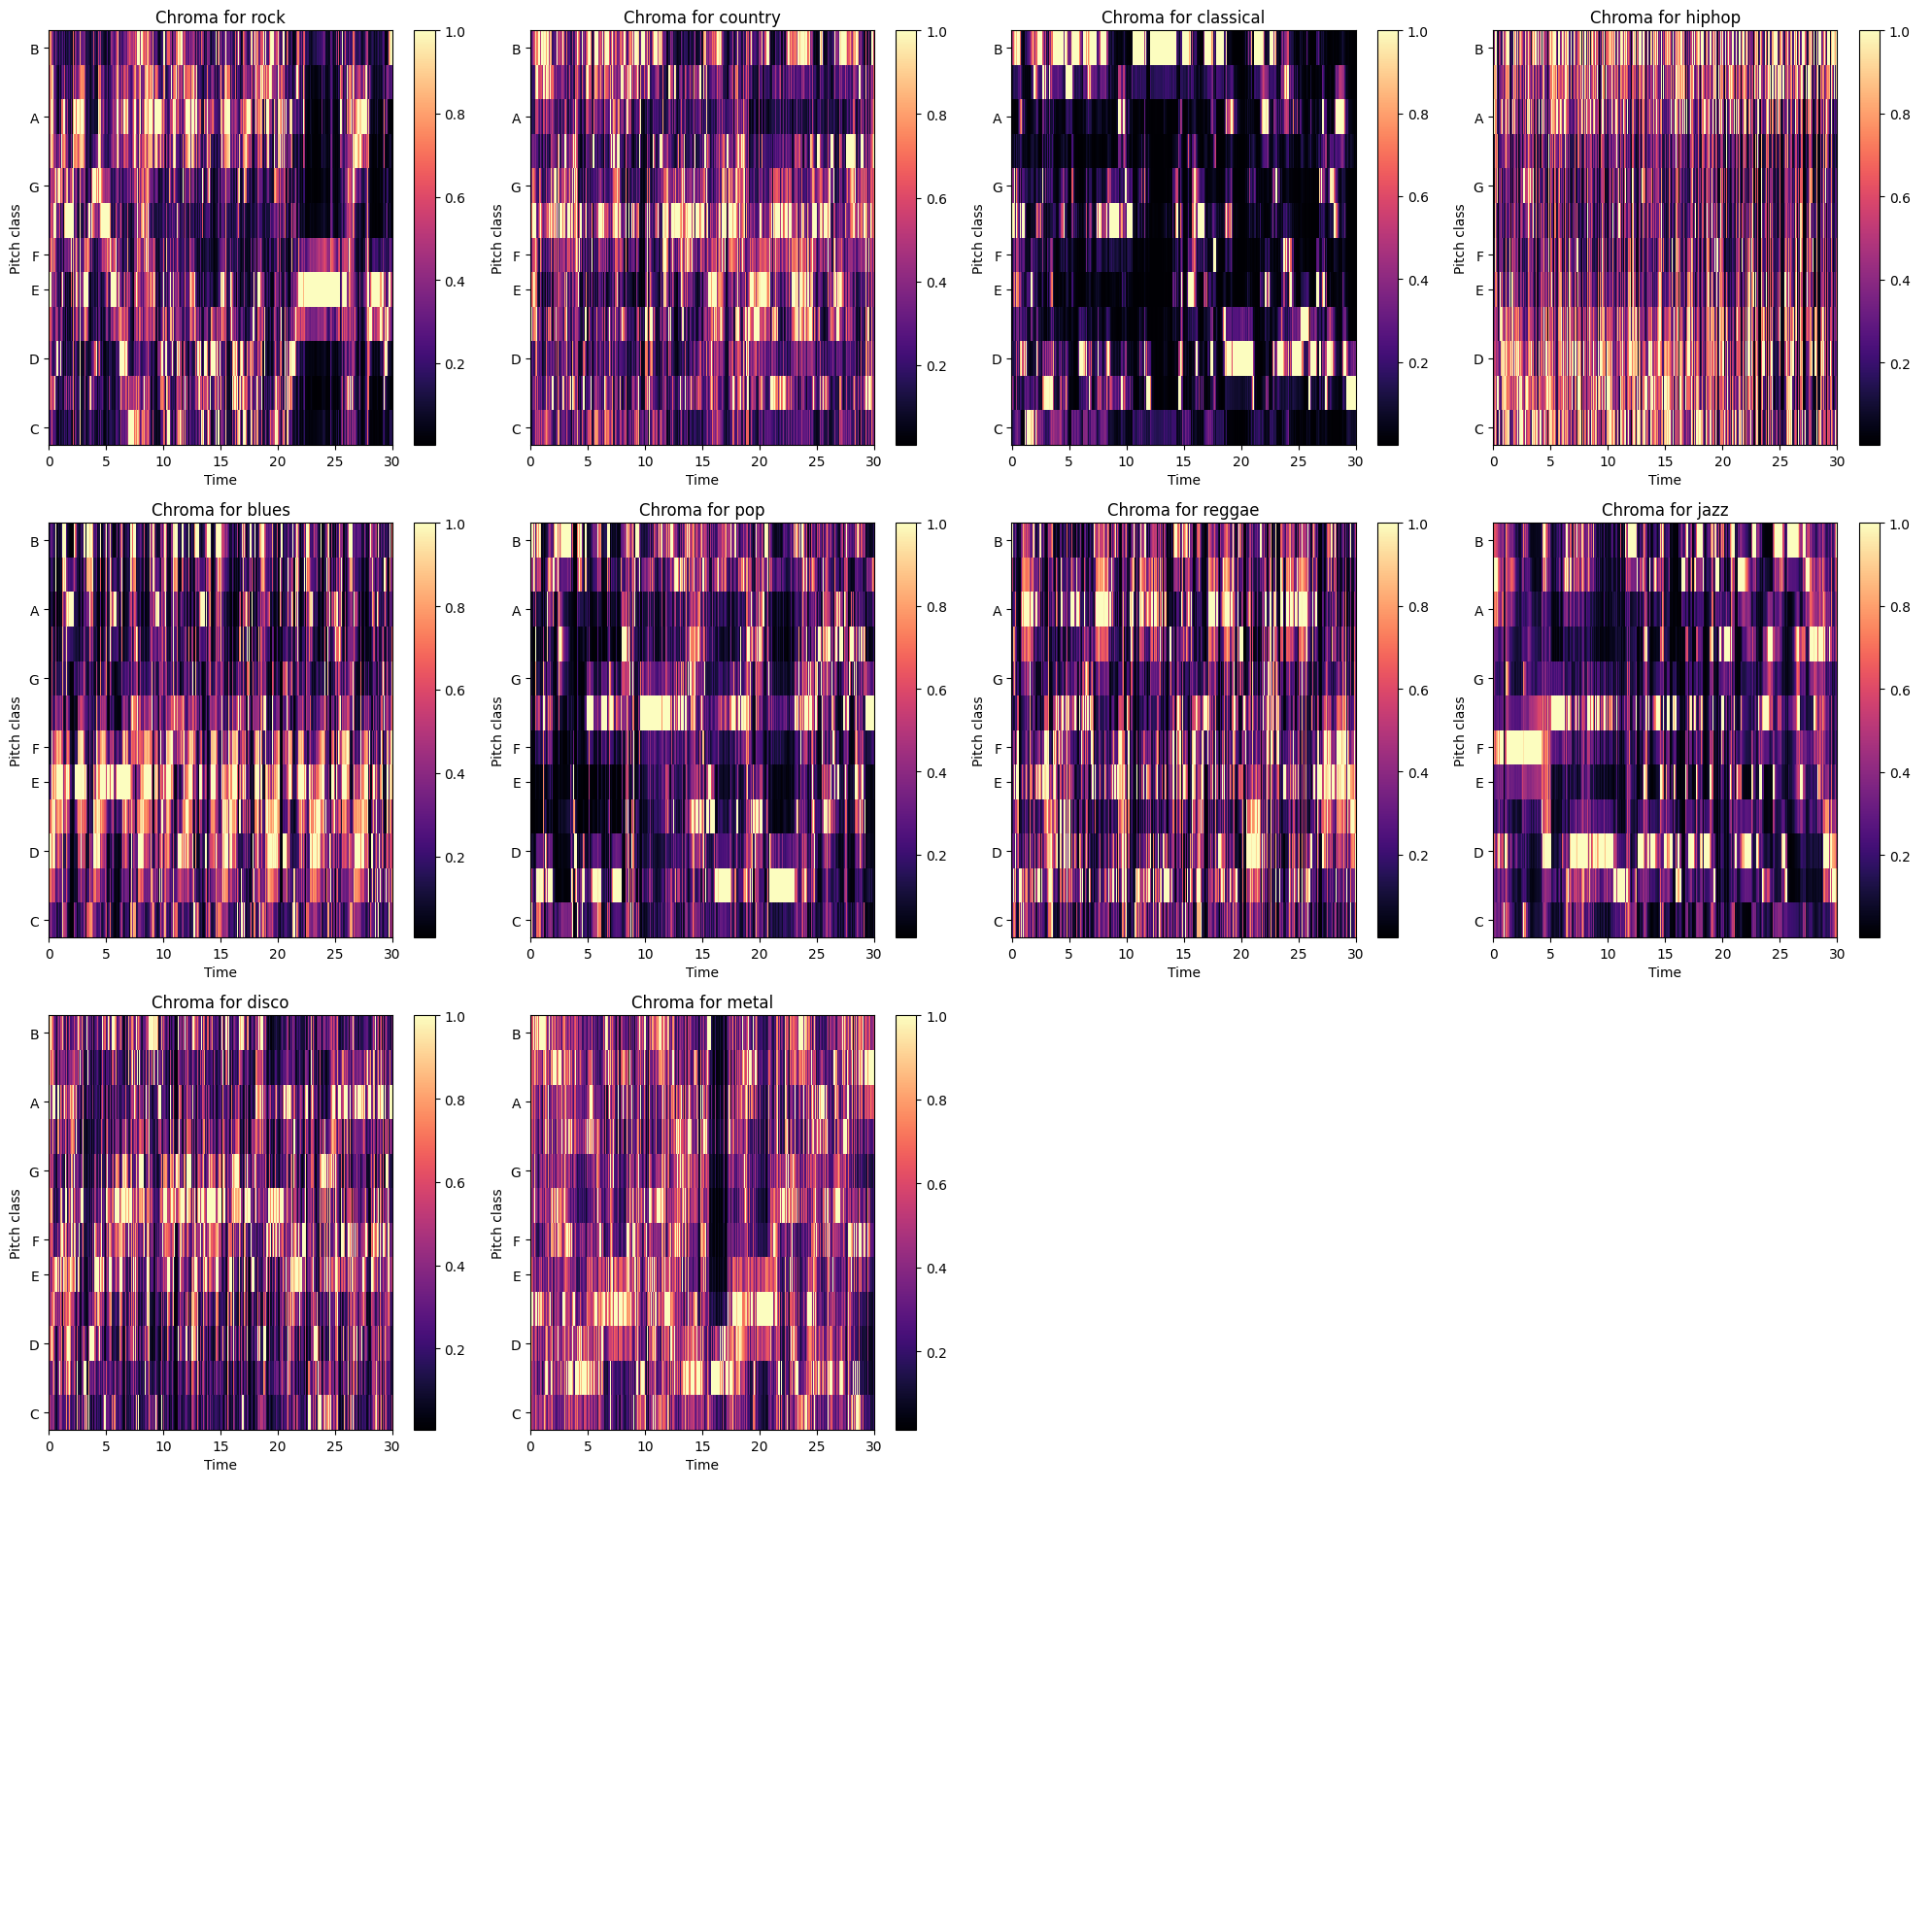

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

# Plot Chroma
for i, genre in enumerate(genres):
    genre_path = os.path.join(dataset_path, genre)
    file_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    y, sr = librosa.load(file_path)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axs[i])
    plt.colorbar(axs[i].collections[0], ax=axs[i])
    axs[i].set_title(f'Chroma for {genre}')

    print(f"Genre: {genre}")
    print(f"  File: {os.path.basename(file_path)}")
    print(f"  Chroma shape: {chroma.shape}")
    print(f"  Mean of Chroma: {np.mean(chroma, axis=1)}")
    print(f"  Standard deviation of Chroma: {np.std(chroma, axis=1)}")
    print(f"  Min/Max of Chroma: {np.min(chroma)}/{np.max(chroma)}")
    print("-" * 40)

for i in range(len(genres), 16):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### What Can We Learn from Chroma Features?

- The transitions between pitch classes over time can reveal chord progressions. For example, a sequence of bright spots moving vertically might indicate a chord change.

- Genres like rock, blues, pop, and hip-hop show dense chroma activity, indicating frequent chord changes.

- Classical and jazz have more structured patterns (jazz is showing more harmonic complexity).

- The pitch class with the highest intensity over time often indicates the tonal center (key) of the music.

## Mel Spectrogram Analysis

A Mel Spectrogram is a visual representation of the frequency content of an audio signal over time, mapped to the Mel scale.

It approximates the human ear's response to different frequencies. It emphasizes lower frequencies (where humans are more sensitive) and compress higher frequencies.

Genre: rock
  File: rock.00001.wav
  Mel Spectrogram shape: (128, 1293)
  Min/Max of Mel Spectrogram: 2.826445522075005e-09/1863.4693603515625
----------------------------------------
Genre: country
  File: country.00001.wav
  Mel Spectrogram shape: (128, 1293)
  Min/Max of Mel Spectrogram: 0.0007156519568525255/1637.671630859375
----------------------------------------
Genre: classical
  File: classical.00001.wav
  Mel Spectrogram shape: (128, 1293)
  Min/Max of Mel Spectrogram: 2.4632358375242802e-09/189.7095184326172
----------------------------------------
Genre: hiphop
  File: hiphop.00003.wav
  Mel Spectrogram shape: (128, 1293)
  Min/Max of Mel Spectrogram: 2.9310920357517034e-09/5526.650390625
----------------------------------------
Genre: blues
  File: blues.00003.wav
  Mel Spectrogram shape: (128, 1293)
  Min/Max of Mel Spectrogram: 2.611946658959141e-09/3565.408447265625
----------------------------------------
Genre: pop
  File: pop.00005.wav
  Mel Spectrogram shape: (128,

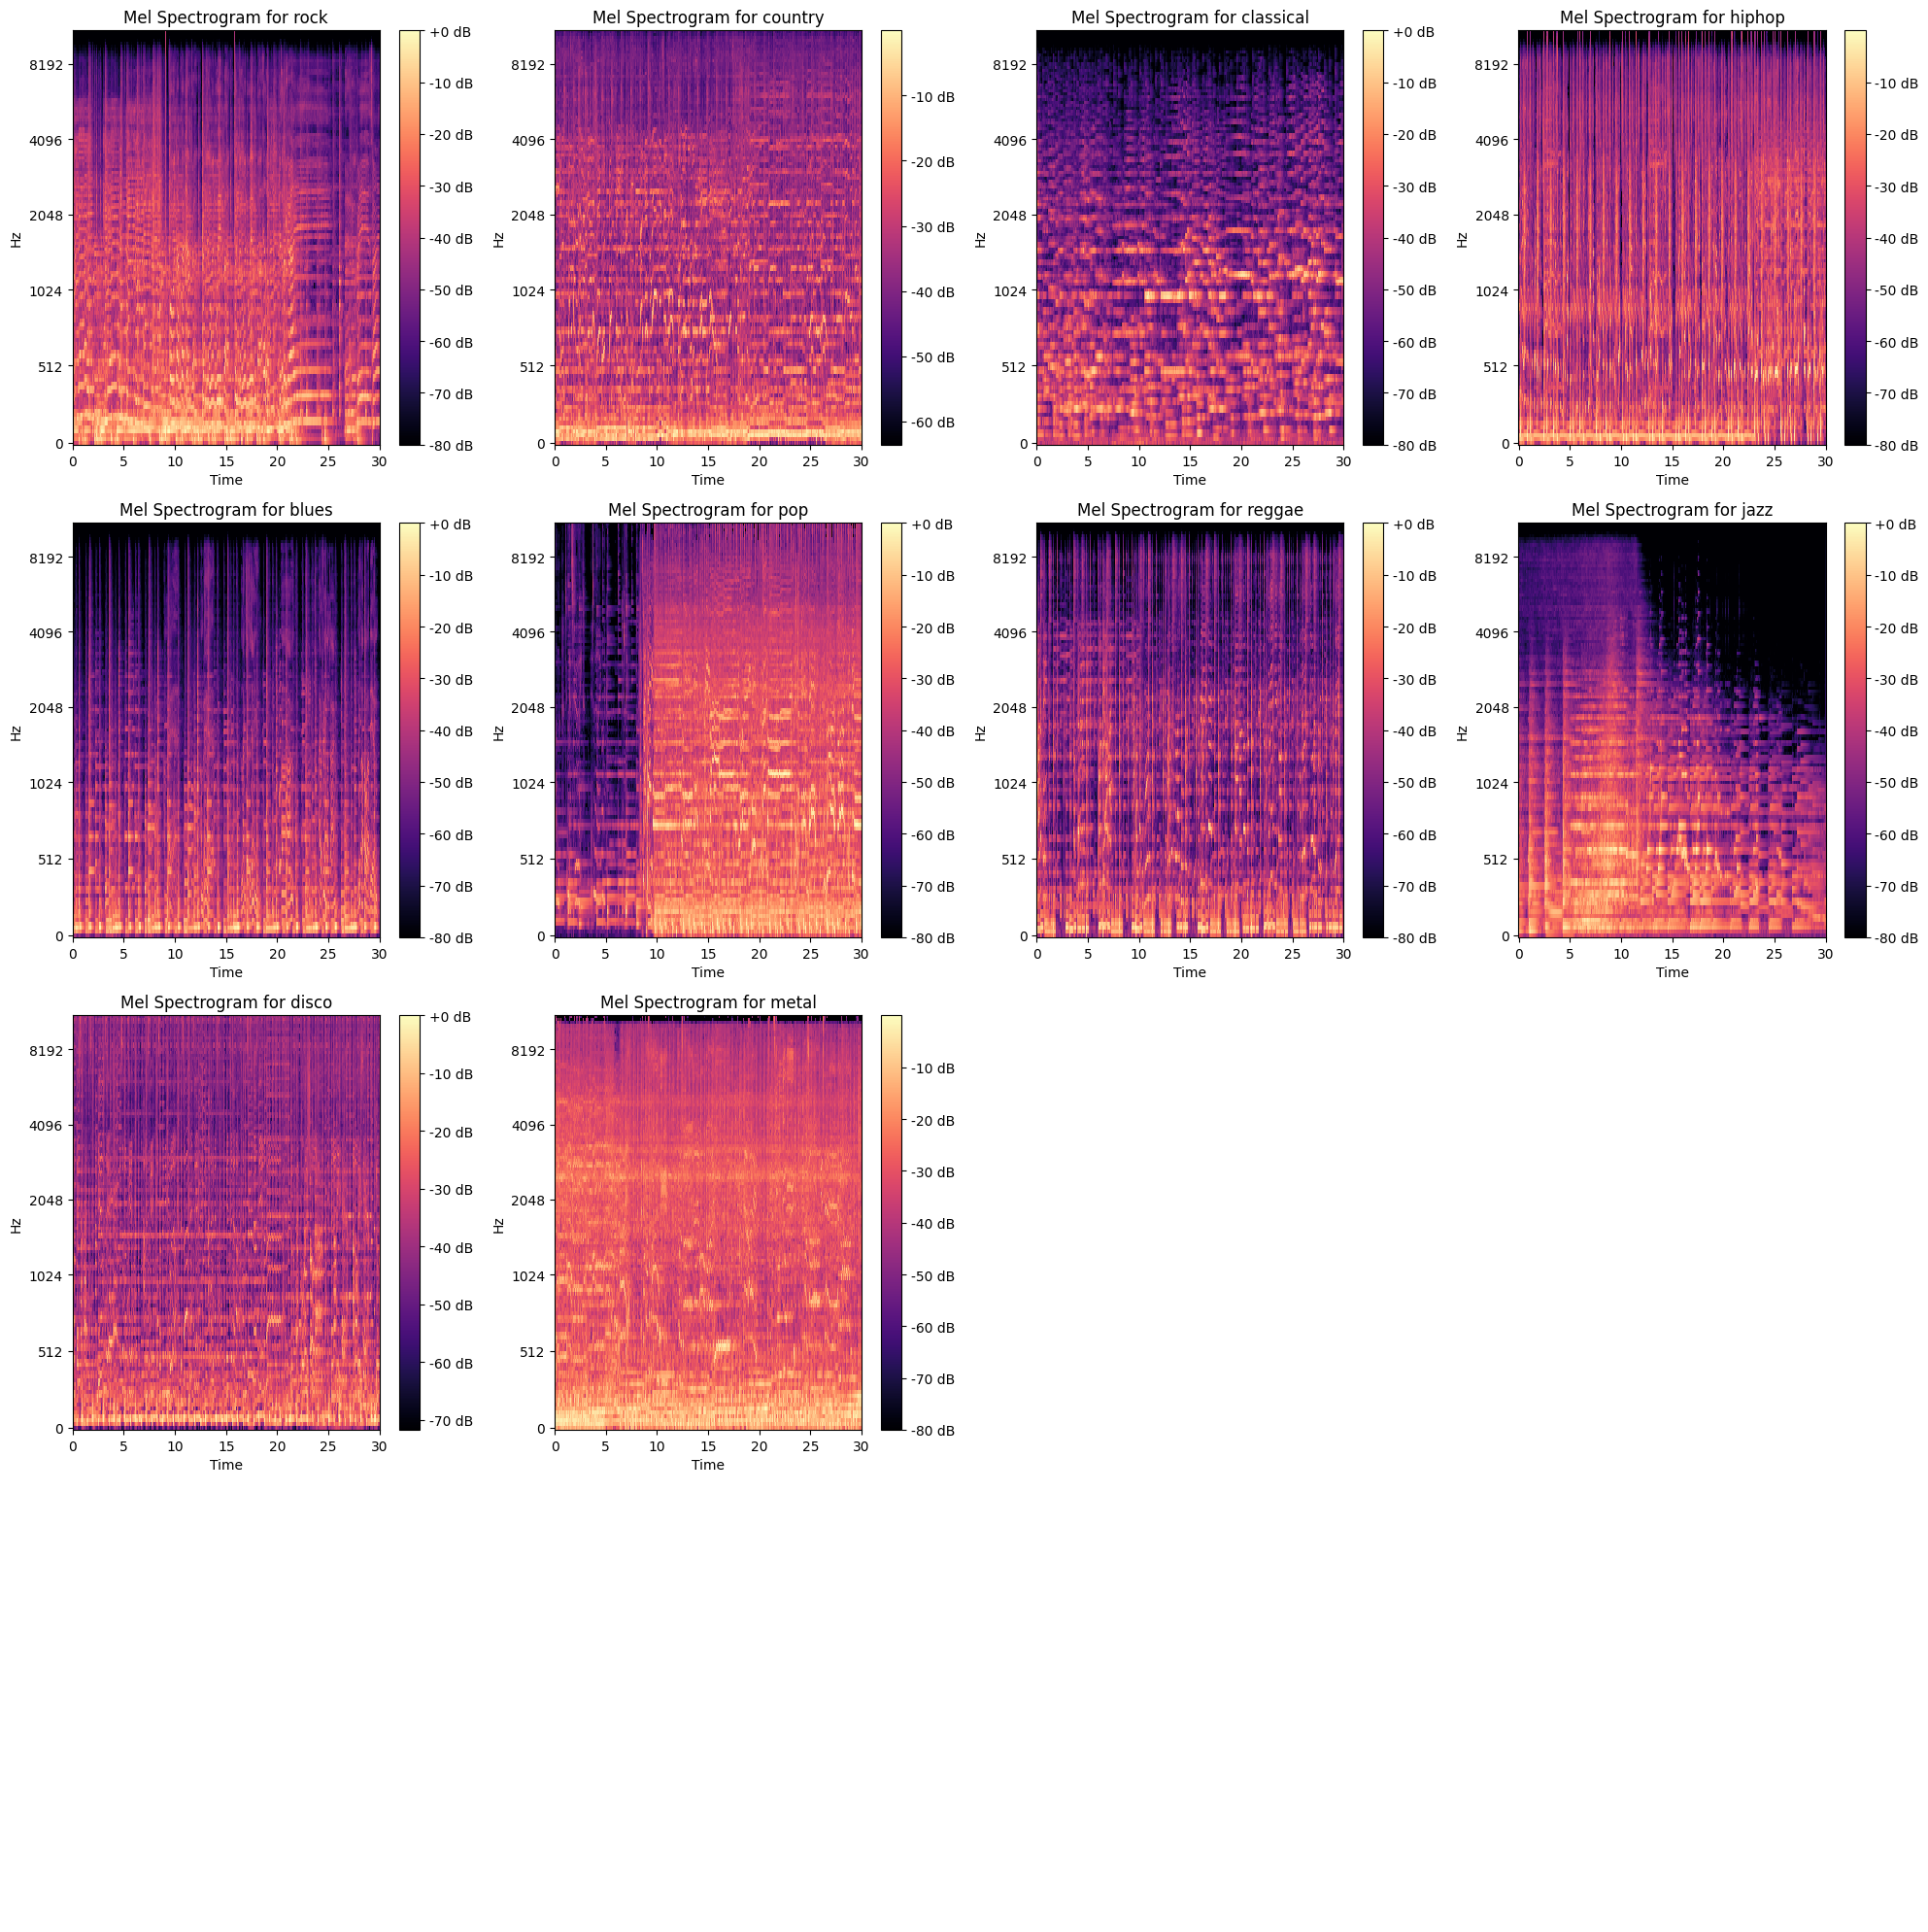

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

# Plot Mel Spectrogram
for i, genre in enumerate(genres):
    genre_path = os.path.join(dataset_path, genre)
    file_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    y, sr = librosa.load(file_path)

    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    librosa.display.specshow(mel_db, y_axis='mel', x_axis='time', ax=axs[i])
    plt.colorbar(axs[i].collections[0], ax=axs[i], format='%+2.0f dB')
    axs[i].set_title(f'Mel Spectrogram for {genre}')

    print(f"Genre: {genre}")
    print(f"  File: {os.path.basename(file_path)}")
    print(f"  Mel Spectrogram shape: {mel.shape}")
    print(f"  Min/Max of Mel Spectrogram: {np.min(mel)}/{np.max(mel)}")
    print("-" * 40)

for i in range(len(genres), 16):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### What Can We Learn from Mel Spectrograms?

| Genre      | Low Frequencies (Bass/Drums) | Mid Frequencies (Guitar/Piano) | High Frequencies (Vocals/Percussion) | Density & Variation |
|------------|-----------------------------|---------------------------------|---------------------------------|-------------------|
| **Rock**   | Strong          | High      | Present, less prominent     | Dense  |
| **Country**| Moderate        | Strong    | Present, less percussive    | Structured |
| **Classical** | Low          | Strong    | Strong                      | Highly structured |
| **Hip-Hop** | Strong         | Moderate  | Sparse, rhythmic           | Repetitive |
| **Blues**  | Moderate       | Smooth    | Moderate, rhythmic         | Improvised |
| **Pop**    | Balanced       | Present, cleaner than rock | Present, bright | Repetitive |
| **Reggae** | Strong         | Present, rhythmic stabs   | Moderate         | Offbeat structure |
| **Jazz**   | Variable       | High      | Present, dynamic changes   | Highly varied |
| **Disco**  | Moderate       | Present, rhythmic        | Present, bright  | Rhythmic, consistent |
| **Metal**  | Strong         | Strong, distorted       | Harsh, intense   | Dense, aggressive |


# Genre Classification

In [10]:
def extract_features(file_path, sr=22050, duration=30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    # chroma_stft (mean, var)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma)
    chroma_stft_var = np.var(chroma)

    # rms (mean, var)
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_var = np.var(rms)

    # spectral_centroid (mean, var)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spec_centroid)
    spectral_centroid_var = np.var(spec_centroid)

    # spectral_bandwidth (mean, var)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spec_bandwidth)
    spectral_bandwidth_var = np.var(spec_bandwidth)

    # rolloff (mean, var)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_var = np.var(rolloff)

    # zero_crossing_rate (mean, var)
    zcr = librosa.feature.zero_crossing_rate(y)
    zero_crossing_rate_mean = np.mean(zcr)
    zero_crossing_rate_var = np.var(zcr)

    # harmony_mean, harmony_var, perceptr_mean, perceptr_var
    y_harm, y_perc = librosa.effects.hpss(y)
    harmony_mean = np.mean(y_harm)
    harmony_var = np.var(y_harm)
    perceptr_mean = np.mean(y_perc)
    perceptr_var = np.var(y_perc)

    # tempo
    tempo = librosa.beat.tempo(y=y, sr=sr)
    if len(tempo) > 0:
        tempo = tempo[0]
    else:
        tempo = 0.0

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc1_mean  = np.mean(mfcc[0]);  mfcc1_var  = np.var(mfcc[0])
    mfcc2_mean  = np.mean(mfcc[1]);  mfcc2_var  = np.var(mfcc[1])
    mfcc3_mean  = np.mean(mfcc[2]);  mfcc3_var  = np.var(mfcc[2])
    mfcc4_mean  = np.mean(mfcc[3]);  mfcc4_var  = np.var(mfcc[3])
    mfcc5_mean  = np.mean(mfcc[4]);  mfcc5_var  = np.var(mfcc[4])
    mfcc6_mean  = np.mean(mfcc[5]);  mfcc6_var  = np.var(mfcc[5])
    mfcc7_mean  = np.mean(mfcc[6]);  mfcc7_var  = np.var(mfcc[6])
    mfcc8_mean  = np.mean(mfcc[7]);  mfcc8_var  = np.var(mfcc[7])
    mfcc9_mean  = np.mean(mfcc[8]);  mfcc9_var  = np.var(mfcc[8])
    mfcc10_mean = np.mean(mfcc[9]);  mfcc10_var = np.var(mfcc[9])
    mfcc11_mean = np.mean(mfcc[10]); mfcc11_var = np.var(mfcc[10])
    mfcc12_mean = np.mean(mfcc[11]); mfcc12_var = np.var(mfcc[11])
    mfcc13_mean = np.mean(mfcc[12]); mfcc13_var = np.var(mfcc[12])
    mfcc14_mean = np.mean(mfcc[13]); mfcc14_var = np.var(mfcc[13])
    mfcc15_mean = np.mean(mfcc[14]); mfcc15_var = np.var(mfcc[14])
    mfcc16_mean = np.mean(mfcc[15]); mfcc16_var = np.var(mfcc[15])
    mfcc17_mean = np.mean(mfcc[16]); mfcc17_var = np.var(mfcc[16])
    mfcc18_mean = np.mean(mfcc[17]); mfcc18_var = np.var(mfcc[17])
    mfcc19_mean = np.mean(mfcc[18]); mfcc19_var = np.var(mfcc[18])
    mfcc20_mean = np.mean(mfcc[19]); mfcc20_var = np.var(mfcc[19])

    feature_vector = np.array([
        chroma_stft_mean, chroma_stft_var,
        rms_mean, rms_var,
        spectral_centroid_mean, spectral_centroid_var,
        spectral_bandwidth_mean, spectral_bandwidth_var,
        rolloff_mean, rolloff_var,
        zero_crossing_rate_mean, zero_crossing_rate_var,
        harmony_mean, harmony_var,
        perceptr_mean, perceptr_var,
        tempo,
        mfcc1_mean, mfcc1_var,
        mfcc2_mean, mfcc2_var,
        mfcc3_mean, mfcc3_var,
        mfcc4_mean, mfcc4_var,
        mfcc5_mean, mfcc5_var,
        mfcc6_mean, mfcc6_var,
        mfcc7_mean, mfcc7_var,
        mfcc8_mean, mfcc8_var,
        mfcc9_mean, mfcc9_var,
        mfcc10_mean, mfcc10_var,
        mfcc11_mean, mfcc11_var,
        mfcc12_mean, mfcc12_var,
        mfcc13_mean, mfcc13_var,
        mfcc14_mean, mfcc14_var,
        mfcc15_mean, mfcc15_var,
        mfcc16_mean, mfcc16_var,
        mfcc17_mean, mfcc17_var,
        mfcc18_mean, mfcc18_var,
        mfcc19_mean, mfcc19_var,
        mfcc20_mean, mfcc20_var,
    ], dtype=np.float32)

    return feature_vector

features_list = []
song_paths = []

print("Extracting features from audio files...")

for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    if not os.path.isdir(genre_path):
        continue
    files = os.listdir(genre_path)

    for file_name in files:
        file_path = os.path.join(genre_path, file_name)
        if not os.path.isfile(file_path):
            continue
        try:
            feat = extract_features(file_path)
            features_list.append(feat)
            song_paths.append(file_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

features_array = np.array(features_list)
print(f"Total songs processed: {len(features_array)}")
print(f"Feature dimension: {features_array.shape[1]}")

Extracting features from audio files...


<ipython-input-10-c4c92535134b>:42: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)


Total songs processed: 999
Feature dimension: 38


In [11]:
columns = [
    "chroma_stft_mean", "chroma_stft_var",
    "rms_mean", "rms_var",
    "spectral_centroid_mean", "spectral_centroid_var",
    "spectral_bandwidth_mean", "spectral_bandwidth_var",
    "rolloff_mean", "rolloff_var",
    "zero_crossing_rate_mean", "zero_crossing_rate_var",
    "harmony_mean", "harmony_var",
    "perceptr_mean", "perceptr_var",
    "tempo",
    "mfcc1_mean", "mfcc1_var",
    "mfcc2_mean", "mfcc2_var",
    "mfcc3_mean", "mfcc3_var",
    "mfcc4_mean", "mfcc4_var",
    "mfcc5_mean", "mfcc5_var",
    "mfcc6_mean", "mfcc6_var",
    "mfcc7_mean", "mfcc7_var",
    "mfcc8_mean", "mfcc8_var",
    "mfcc9_mean", "mfcc9_var",
    "mfcc10_mean", "mfcc10_var",
    "mfcc11_mean", "mfcc11_var",
    "mfcc12_mean", "mfcc12_var",
    "mfcc13_mean", "mfcc13_var",
    "mfcc14_mean", "mfcc14_var",
    "mfcc15_mean", "mfcc15_var",
    "mfcc16_mean", "mfcc16_var",
    "mfcc17_mean", "mfcc17_var",
    "mfcc18_mean", "mfcc18_var",
    "mfcc19_mean", "mfcc19_var",
    "mfcc20_mean", "mfcc20_var",
]

df = pd.DataFrame(features_array, columns=columns)
df.insert(0, 'file_path', song_paths)

output_csv = "audio_features.csv"
df.to_csv(output_csv, index=False)
print(f"Features saved to {output_csv}")

Features saved to audio_features.csv


# XGBoost

XGBoost is an ensemble learning method that builds a series of decision trees sequentially. Each tree corrects the errors of the previous one, leading to a highly accurate model.



In [15]:
# Features Loading
audio_features = "/content/audio_features.csv"
data = pd.read_csv(audio_features)

data['label'] = data['file_path'].apply(lambda x: x.split('/')[-2])

print(data.head())

X = data.drop(columns=["file_path", "label"])
y = data["label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

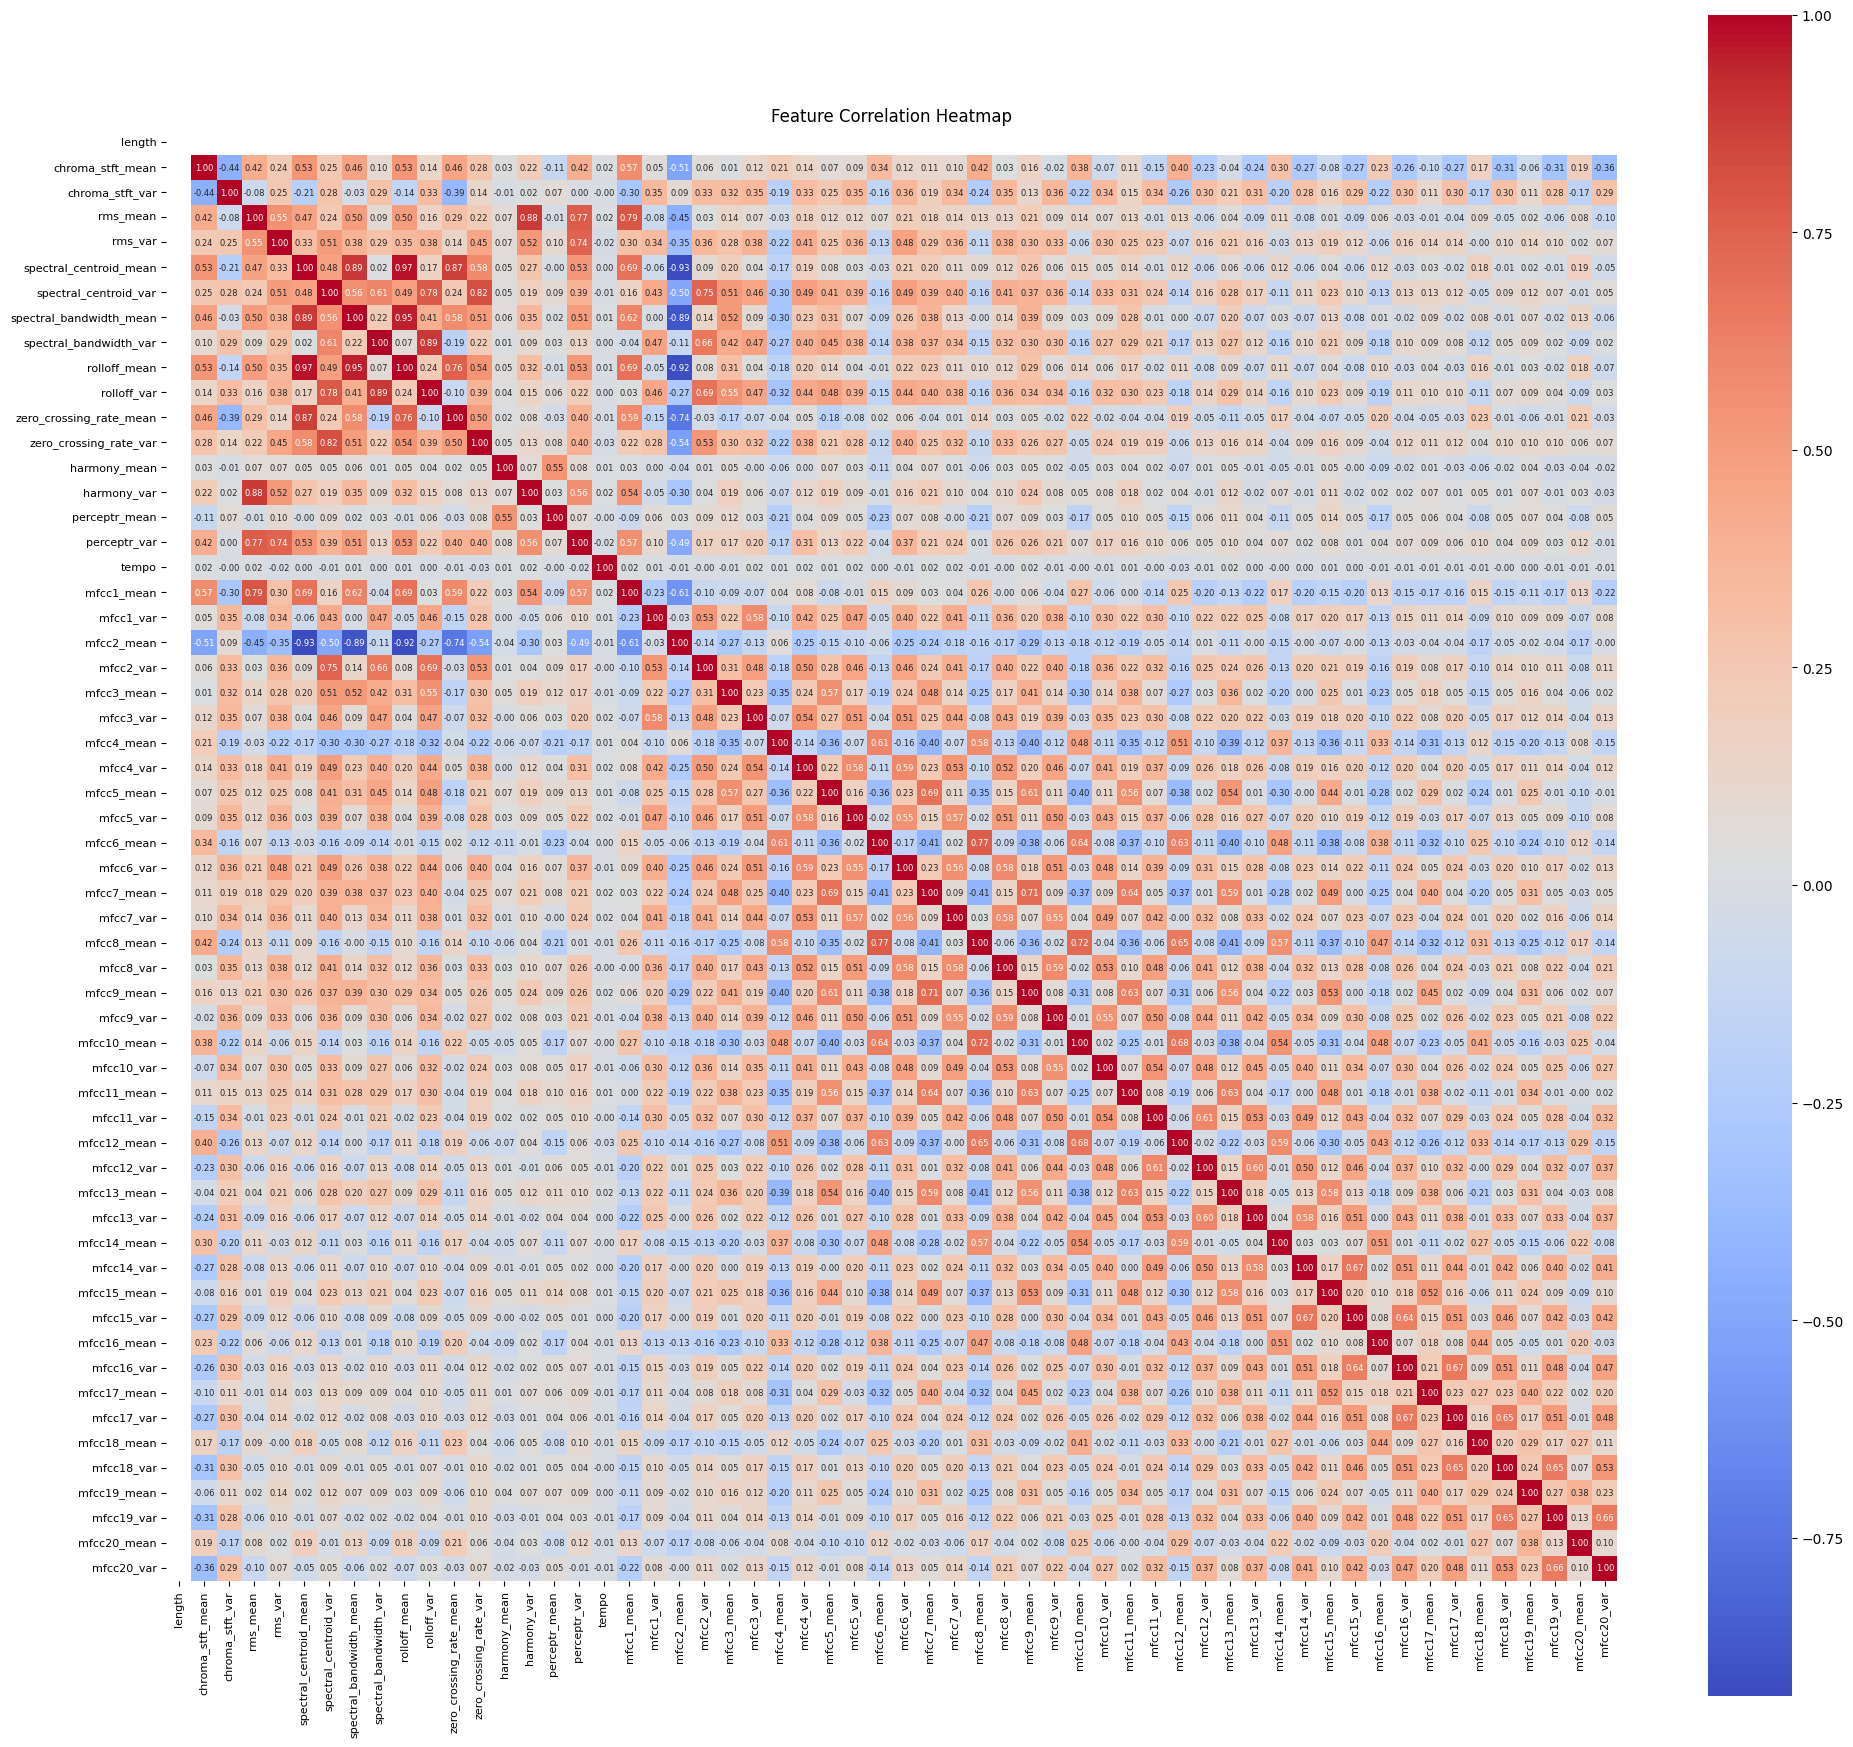

In [16]:
# Correlation Heatmap
plt.figure(figsize=(20, 18))
corr = X.corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    annot_kws={"size": 6}
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

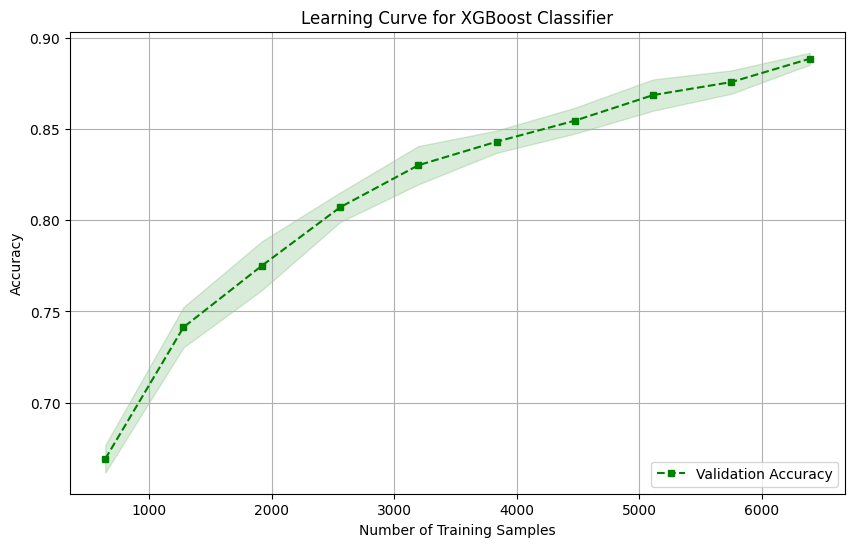

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:16:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 91.09%

Classification Report:
              precision    recall  f1-score   support

       blues       0.90      0.89      0.89       208
   classical       0.93      0.97      0.95       203
     country       0.81      0.87      0.84       186
       disco       0.89      0.90      0.90       199
      hiphop       0.96      0.90      0.93       218
        jazz       0.88      0.92      0.90       192
       metal       0.94      0.96      0.95       204
         pop       0.95      0.96      0.96       180
      reggae       0.93      0.91      0.92       211
        rock       0.91      0.84      0.87       197

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Mean & Standard Deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Learning Curve for XGBoost Classifier')
plt.show()

# Fit
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

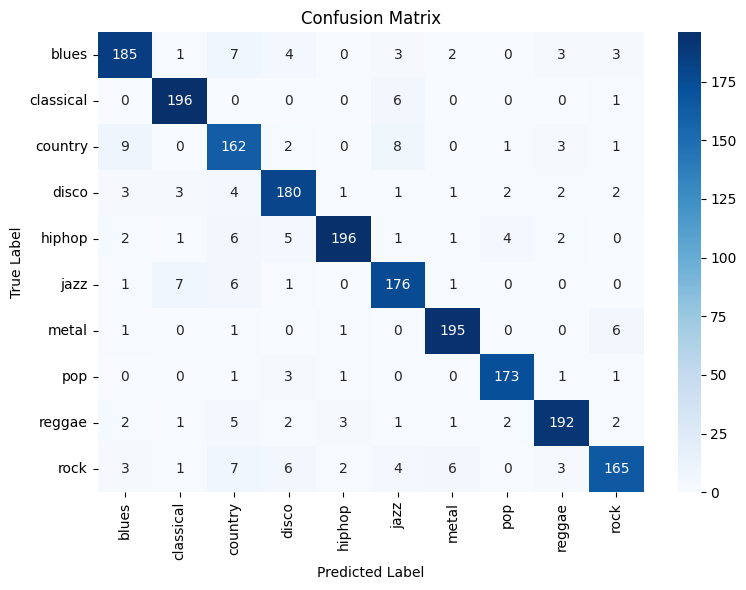

<ipython-input-18-6bfb1bcc36fa>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


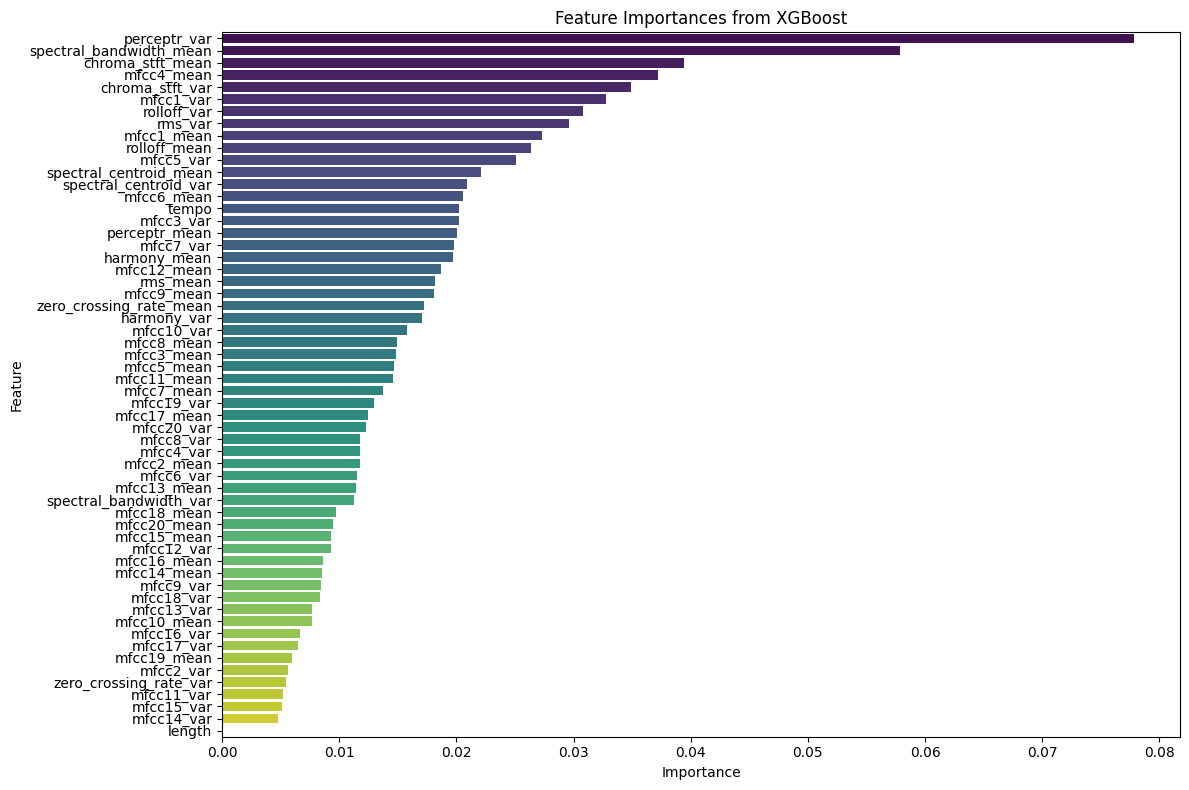

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importances from the XGBoost
importances = xgb_model.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importances from XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# YAMNet

YAMNet is a pre-trained deep learning model based on the MobileNet architecture designed for audio classification.

We use YAMNet as a feature extractor. Instead of training a model from scratch to understand raw audio, we will leverage YAMNet to convert audio waveforms into meaningful feature representations.

In [20]:
genre_to_label = {genre: i for i, genre in enumerate(genres)}

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
print("YAMNet model loaded.")

def extract_embedding(audio_path):
    try:
        waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

    waveform = waveform.astype(np.float32)
    # waveform is fed into YAMNet
    scores, embeddings, spectrogram = yamnet_model(waveform)
    embedding_mean = tf.reduce_mean(embeddings, axis=0)
    return embedding_mean.numpy()

embeddings_list = []
labels_list = []

for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    files = os.listdir(genre_path)
    print(f"Processing Genre: {genre} with {len(files)} files.")
    for file in files:
        audio_path = os.path.join(genre_path, file)
        emb = extract_embedding(audio_path)
        if emb is not None:
            embeddings_list.append(emb)
            labels_list.append(genre_to_label[genre])

# Preparing Data
X = np.array(embeddings_list)
y = np.array(labels_list)
print("Shape of embeddings:", X.shape)
print("Shape of labels:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Classifier
num_genres = len(genres)
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_genres, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=16,
                    validation_data=(X_test, y_test))

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

YAMNet model loaded.
Processing Genre: rock with 100 files.
Processing Genre: country with 100 files.
Processing Genre: classical with 100 files.
Processing Genre: hiphop with 100 files.
Processing Genre: blues with 100 files.
Processing Genre: pop with 100 files.
Processing Genre: reggae with 100 files.
Processing Genre: jazz with 99 files.
Processing Genre: disco with 100 files.
Processing Genre: metal with 100 files.
Shape of embeddings: (999, 1024)
Shape of labels: (999,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,490 (517.54 KB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4172 - loss: 1.8314 - val_accuracy: 0.8050 - val_loss: 0.7994
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7524 - loss: 0.7896 - val_accuracy: 0.8300 - val_loss: 0.5945
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8164 - loss: 0.6328 - val_accuracy: 0.8200 - val_loss: 0.5449
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8327 - loss: 0.5799 - val_accuracy: 0.8100 - val_loss: 0.5290
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8461 - loss: 0.4835 - val_accuracy: 0.8150 - val_loss: 0.5075
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8491 - loss: 0.4695 - val_accuracy: 0.8250 - val_loss: 0.4981
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8544 - loss: 0.4803 - val_accuracy: 0.8300 - val_loss: 0.5033
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8812 - loss: 0.4026 - val_accuracy: 0.8200 - val_los

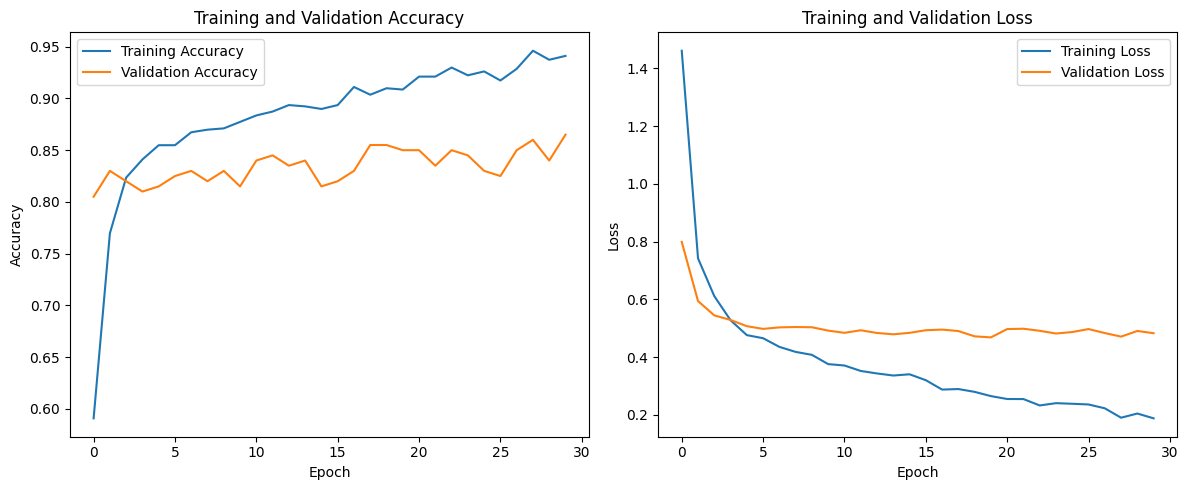

In [21]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


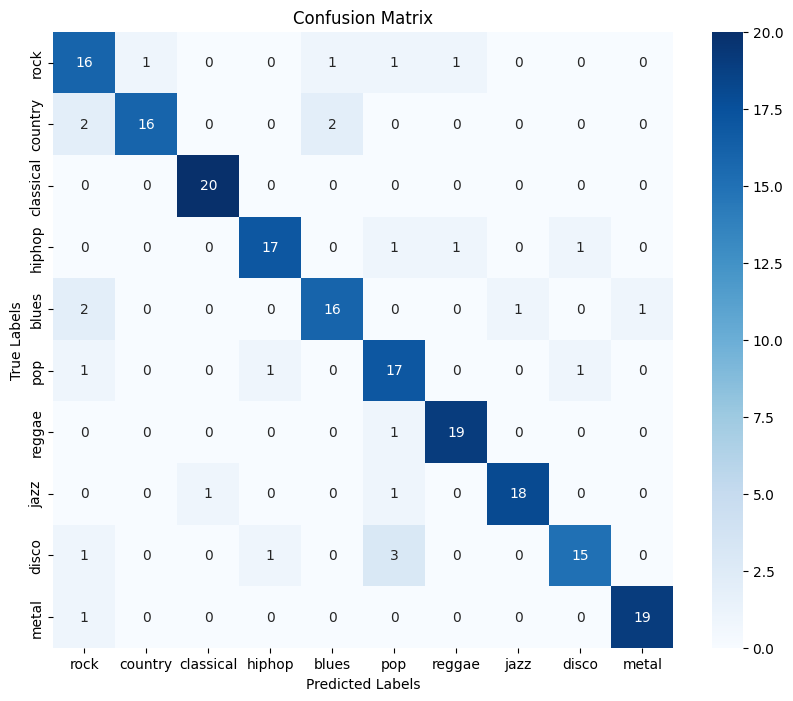

Classification Report:
              precision    recall  f1-score   support

        rock       0.70      0.80      0.74        20
     country       0.94      0.80      0.86        20
   classical       0.95      1.00      0.98        20
      hiphop       0.89      0.85      0.87        20
       blues       0.84      0.80      0.82        20
         pop       0.71      0.85      0.77        20
      reggae       0.90      0.95      0.93        20
        jazz       0.95      0.90      0.92        20
       disco       0.88      0.75      0.81        20
       metal       0.95      0.95      0.95        20

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.87       200
weighted avg       0.87      0.86      0.87       200



In [23]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = y_test

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=genres))

# KNN - Music Recommendation


Input Song:
/content/drive/MyDrive/AI/data/genres_original/rock/rock.00001.wav

Recommended Similar Songs and Similarity Percentages:
/content/drive/MyDrive/AI/data/genres_original/blues/blues.00002.wav - Similarity: 70.21%
/content/drive/MyDrive/AI/data/genres_original/blues/blues.00088.wav - Similarity: 69.62%
/content/drive/MyDrive/AI/data/genres_original/rock/rock.00009.wav - Similarity: 68.80%
/content/drive/MyDrive/AI/data/genres_original/metal/metal.00089.wav - Similarity: 67.66%
/content/drive/MyDrive/AI/data/genres_original/rock/rock.00004.wav - Similarity: 65.27%


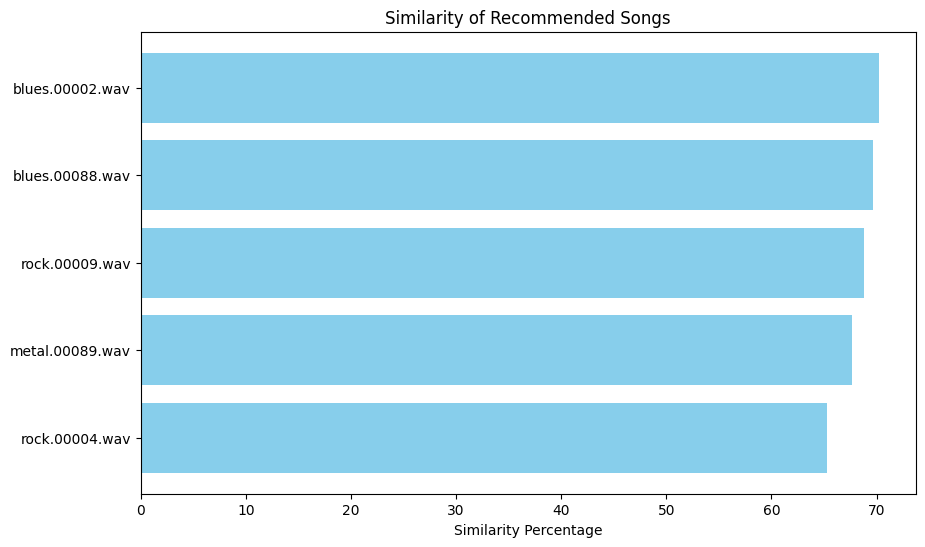

In [24]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Model - KNN with Cosine Distance
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(features_scaled)

# Recommendation
def recommend_songs(song_index, model, features_scaled, song_paths, num_recommendations=5):
    distances, indices = model.kneighbors([features_scaled[song_index]])

    recommended_indices = indices[0][1:num_recommendations+1]
    recommended_distances = distances[0][1:num_recommendations+1]

    similarity_percentages = (1 - recommended_distances) * 100
    return recommended_indices, similarity_percentages


test_index = 0
rec_indices, sim_scores = recommend_songs(
    song_index=test_index,
    model=nn_model,
    features_scaled=features_scaled,
    song_paths=song_paths,
    num_recommendations=5
)

print("\nInput Song:")
print(song_paths[test_index])
print("\nRecommended Similar Songs and Similarity Percentages:")
for idx, sim in zip(rec_indices, sim_scores):
    print(f"{song_paths[idx]} - Similarity: {sim:.2f}%")

# Plot
plt.figure(figsize=(10, 6))
recommended_song_names = [os.path.basename(song_paths[i]) for i in rec_indices]
plt.barh(recommended_song_names, sim_scores, color='skyblue')
plt.xlabel("Similarity Percentage")
plt.title("Similarity of Recommended Songs")
plt.gca().invert_yaxis()
plt.show()

In [27]:
print("Input Song Preview:")
input_song_path = song_paths[test_index]
input_audio, sr = librosa.load(input_song_path, sr=None, duration=5)
display(Audio(data=input_audio, rate=sr))

print("\nRecommended Songs Previews:\n")
for i, rec_idx in enumerate(rec_indices):
    rec_song_path = song_paths[rec_idx]
    rec_audio, sr = librosa.load(rec_song_path, sr=None, duration=5)
    print(f"Recommendation {i+1}: {os.path.basename(rec_song_path)}")
    display(Audio(data=rec_audio, rate=sr))

Input Song Preview:



Recommended Songs Previews:

Recommendation 1: blues.00002.wav


Recommendation 2: blues.00088.wav


Recommendation 3: rock.00009.wav


Recommendation 4: metal.00089.wav


Recommendation 5: rock.00004.wav
